In [42]:
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.metrics import mean_squared_error

In [43]:
def polynom_orig(x):
    return x * np.sin(2 * np.pi * x)

def error(x):
    return polynom_orig(x) + random.normalvariate(0.0, 0.2)

In [44]:
def generate(N):
    x = np.sort(np.random.uniform(0, 1., N))
    x1 = x[::2]
    x2 = x[1::2]
    y = np.array(list(map(polynom_orig, x)))
    y1 = np.array(list(map(error, x1)))
    y2 = np.array(list(map(error, x2)))

    return x1, y1, x2, y2, x, y

In [45]:
def mse(train, predict):
    return ((train - predict) ** 2).sum() / len(train)

def rmse(train, predict):
    return mse(train, predict) ** 0.5

In [46]:
class Layer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2 / (input_size + 1 + output_size)),
                                        size=(output_size, input_size + 1))

    def forward(self, input):
        input = np.hstack((input, np.ones(1)))
        return self.weights @ input, input

    def grad(self, delta, input, prev_activation):
        dtanh = 1.0 / np.cosh(prev_activation) ** 2
        dtanh = dtanh.reshape(1, dtanh.shape[0]).T
        grad_out = dtanh @ input.reshape(1, input.shape[0])
        grad_w = (delta.reshape(1, delta.shape[0])).T * grad_out
        delta = self.weights.T @ delta
        delta = delta[:self.input_size]
        return grad_w, delta

class MLP:
    def __init__(self, input_size, first_layer_size, second_layer_size, output_layer_size):
        self.input_size = input_size
        self.first_layer_size = first_layer_size
        self.second_layer_size = second_layer_size
        self.output_layer_size = output_layer_size
        
        self.layer1 = Layer(input_size, first_layer_size)
        self.layer2 = Layer(first_layer_size, second_layer_size)
        self.layer3 = Layer(second_layer_size, output_layer_size)

    def forward(self, input):
        out1, input1 = self.layer1.forward(input)
        tanh1 = np.tanh(out1)
        
        out2, input2 = self.layer2.forward(tanh1)
        tanh2 = np.tanh(out2)
        
        out3, input3 = self.layer3.forward(tanh2)
        tanh3 = np.tanh(out3)
        
        return [input1, input2, input3], [out1, out2, out3], [tanh1, tanh2, tanh3]

    def _update_weights(self, gradients, lr):
        self.layer1.weights -= lr * gradients[0]
        self.layer2.weights -= lr * gradients[1]
        self.layer3.weights -= lr * gradients[2]

    def fit(self, lr, epoch_count, train_X, train_Y, verbose = True):
        mse_list = []
        
        for i in range(epoch_count):
            grads = [np.zeros_like(self.layer1.weights),
                     np.zeros_like(self.layer2.weights),
                     np.zeros_like(self.layer3.weights)]
            
            avg_mse = 0.0
            for j in range(len(train_X)):
                x = train_X[j]
                y = train_Y[j]
                
                [input1, input2, input3], [out1, out2, out3], prev_outputs = self.forward(x)
                
                error = prev_outputs[-1] - y
                w3_grad, error = self.layer3.grad(error, input3, out3)
                w2_grad, error = self.layer2.grad(error, input2, out2)
                w1_grad, error = self.layer1.grad(error, input1, out1)
                
                grads[0] += w1_grad
                grads[1] += w2_grad
                grads[2] += w3_grad
                
                avg_mse += mse(prev_outputs[-1], y)
            
            avg_mse /= len(train_X)
            
            if (i % 100 == 0 and verbose):
              print("epoch: ", i, ": MSE = ", avg_mse)
            
            mse_list.append(avg_mse)
            self._update_weights(grads, lr)
        return mse_list

    def eval(self, test_X, test_Y):
        res = []
        error_list = []
        
        for i in range(len(test_X)):
            x = test_X[i]
            y = test_Y[i]
            _, _, prev_outputs = self.forward(x)
            res.append(prev_outputs[-1])
            error_list.append(mse(prev_outputs[-1], y))
        
        return res, error_list

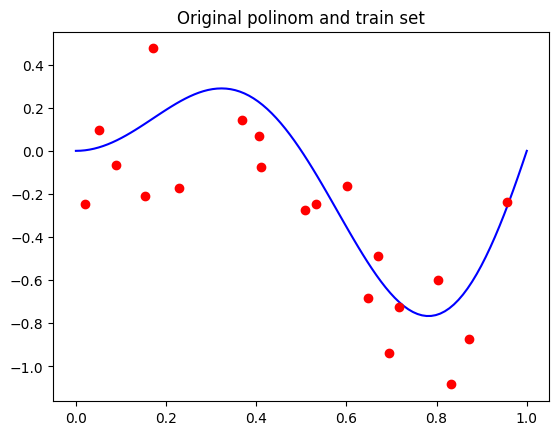

In [47]:
N = 40
trainX, trainY, testX, testY, allX, allY = generate(N)

z = np.linspace(0., 1., 100)
plt.title('Original polinom and train set')
plt.plot(z, polynom_orig(z), 'b-')
plt.plot(trainX, trainY, 'ro')
plt.show()

In [48]:
model = MLP(1, 80, 80, 1)

In [ ]:
print("Training:")
model.fit(0.001, 1000000, trainX, trainY)

res, errs = model.eval(testX, testY)
sqrt_errs = np.sqrt(errs)
rmse = np.sum(sqrt_errs) / len(sqrt_errs)

print("RMSE on test: ", rmse)

Training:
epoch:  0 : MSE =  0.2884048003209032
epoch:  100 : MSE =  0.09452882498334145
epoch:  200 : MSE =  0.08097439841933038
epoch:  300 : MSE =  0.07914760619890325
epoch:  400 : MSE =  0.07897987847102157
epoch:  500 : MSE =  0.07899914817501341
epoch:  600 : MSE =  0.07902265204010217
epoch:  700 : MSE =  0.07903779269223311
epoch:  800 : MSE =  0.07904829026350811
epoch:  900 : MSE =  0.0790568530477922
epoch:  1000 : MSE =  0.07906471879185753
epoch:  1100 : MSE =  0.07907239691361385
epoch:  1200 : MSE =  0.07908009095347968
epoch:  1300 : MSE =  0.07908788204559021
epoch:  1400 : MSE =  0.07909580299207711
epoch:  1500 : MSE =  0.07910386748083438
epoch:  1600 : MSE =  0.07911208153191686
epoch:  1700 : MSE =  0.07912044797611176
epoch:  1800 : MSE =  0.0791289682062888
epoch:  1900 : MSE =  0.07913764285977033
epoch:  2000 : MSE =  0.07914647208076518
epoch:  2100 : MSE =  0.07915545561765604
epoch:  2200 : MSE =  0.0791645928555803
epoch:  2300 : MSE =  0.0791738828241327

In [ ]:
plt.title("Original and predicted:")
plt.plot(z, polynom_orig(z), 'b-')
mlp_y, mlp_errs = model.eval(z, polynom_orig(z))
plt.plot(z, mlp_y, 'g-')
plt.plot(trainX, trainY, 'ro')
plt.show()